In [1]:
import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

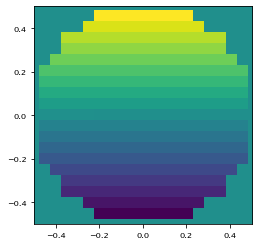

In [2]:
# visualizations of the mode basis elements
imshow_field(zernike(*ansi_to_zernike(1))(make_pupil_grid(21)))

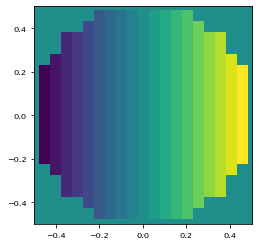

In [3]:
imshow_field(zernike(*ansi_to_zernike(2))(make_pupil_grid(21)))

In [4]:
def pupil(N):

    p = np.zeros([N,N])

    radius = N/2.
    [X,Y] = np.meshgrid(np.linspace(-(N-1)/2.,(N-1)/2.,N),np.linspace(-(N-1)/2.,(N-1)/2.,N))
    R = np.sqrt(pow(X,2)+pow(Y,2))
    p[R<=radius] = 1
    
    return p

def projectOntoDM(Z,nAct,wL):

    # Convert phase to optical path length and halve to
    # compensate for double pass of DM
    Z_DM = Z*wL/(2*np.pi)

    # Set commands only for valid actuators
    p = pupil(nAct)==1

    # Scale commands for Keck DM (1V = 0.6u)
    scale = 0.6e-6
    Z_coefs = Z_DM[p]/scale

    # Remove piston (average)
    #Z_coeffs = Z_coefs - np.mean(Z_coefs)

    return Z_coefs

In [5]:
wavelength = 5e-7
dt    = 1/1000
T     = 1
nAct  = 21
D     = 10.95
r0    = 16.5e-2   
k     = 2 * np.pi / wavelength
scale = 0.6e-6
Z_DM = np.zeros([nAct,nAct])
pup  = pupil(nAct) == 1
binning_factor = 8
pupil_grid     = make_pupil_grid(nAct*binning_factor, D)

t = np.arange(0, T, dt)

## Define Zernike basis set
## We're planning to subtract the first 3 modes: piston, tip, and tilt
mode_basis = make_zernike_basis(num_modes=3, D=D, grid=pupil_grid)
tiptilt = mode_basis[1:3] # the mode basis for just controlling tip and tilt
piston = mode_basis[:2] # the mode basis for just controlling piston

In [6]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)

def sim_turbulence(controlled_modes):
    single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                                  velocity=wind_velocity, use_interpolation=True)
    modal_layer = ModalAdaptiveOpticsLayer(layer=single_layer_atmos, controlled_modes=controlled_modes, lag=0) 
    coeff_size = np.count_nonzero(pupil(nAct))
    single_layer_turb = np.zeros((t.size, coeff_size))
    for n in range(t.size):
        modal_layer.evolve_until(t[n])
        thephase = modal_layer.phase_for(wavelength)
        thephase_binned = thephase.reshape(nAct,binning_factor, nAct, binning_factor).mean(axis=3).mean(axis=1)
        # dimensions nAct x nAct

        ## Remove piston
        Z = thephase_binned * pup
        Z[Z == 0] = np.nan
        #Z = Z - np.nanmean(Z)

        Z_coeffs = projectOntoDM(Z, nAct, wavelength)
        single_layer_turb[n,:] = Z_coeffs
    
    return single_layer_turb

#np.save('./single_layer_turb_volts.npy', single_layer_turb)
turbulence_all = sim_turbulence(mode_basis)
turbulence_tt = sim_turbulence(tiptilt)

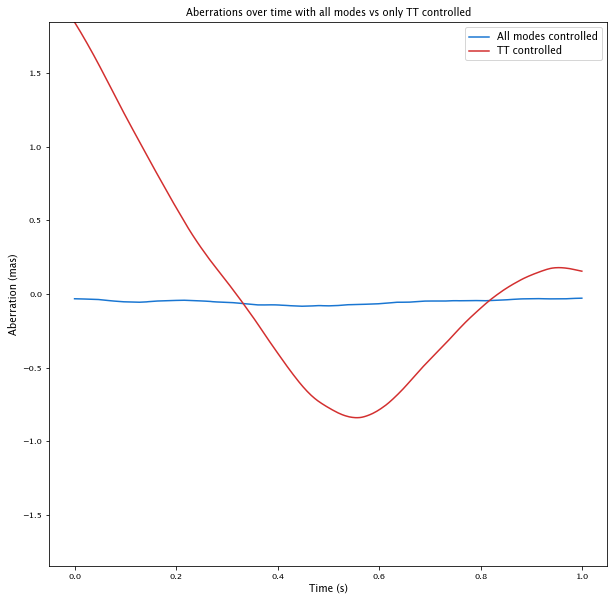

In [7]:
aberrations_all_var = np.sqrt((turbulence_all**2).mean(axis=1))
aberrations_all_orig = turbulence_all.mean(axis=1)
aberrations_tt_var = np.sqrt((turbulence_tt**2).mean(axis=1))
aberrations_tt_orig = turbulence_tt.mean(axis=1)
plt.figure(figsize=(10,10)) 
plt.plot(t, aberrations_all_orig, label='All modes controlled')
plt.plot(t, aberrations_tt_orig, label='TT controlled')
lim = np.max(np.abs(aberrations_tt_orig))
plt.ylim(-lim,lim)
plt.xlabel("Time (s)")
plt.ylabel("Aberration (mas)")
plt.title("Aberrations over time with all modes vs only TT controlled")
plt.legend()

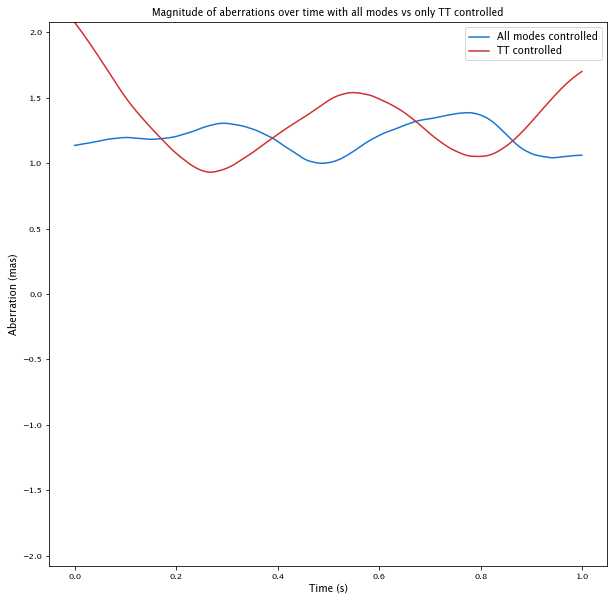

In [8]:
plt.figure(figsize=(10,10))
plt.plot(t, aberrations_all_var, label='All modes controlled')
plt.plot(t, aberrations_tt_var, label='TT controlled')
lim = np.max(np.abs(aberrations_tt_var))
plt.ylim(-lim,lim)
plt.xlabel("Time (s)")
plt.ylabel("Aberration (mas)")
plt.title("Magnitude of aberrations over time with all modes vs only TT controlled")
plt.legend()